<h1><img src="https://www.aisa.digital/wp-content/uploads/2020/09/multilingual-chatbot-300x263.png" width="80" height="80">  <strong>Text Mining and Natural Language Processing Project</strong></h1>
<h2><strong>Parameter Efficient Fine-Tuning with QLora and Unsloth applied to a Machine Translation task</strong></h2>


This project will perform a fine-tuning on a language model with QLora, for parameter efficiency training, and [Unsloth](https://unsloth.ai/), an optimization library for faster training and inference.





## Install dependencies

In [ ]:
# Install core packages
!pip install -q datasets \
                torch==2.9.0 \
                transformers \
                trl \
                accelerate \
                bitsandbytes \
                unsloth \
                evaluate \
                bert_score \
                sacrebleu \
                rouge_score \
                nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.7/405.7 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 14.9 MB/s eta 0:00:00


> ‼️**RESTART RUNTIME**

## Setup Environment

Firstly, let's add required import for training and data analysis




In [ ]:
import unsloth # <--- important to load unsloth at the beginning


from trl import SFTConfig, SFTTrainer, GRPOConfig, GRPOTrainer
from transformers import TrainingArguments, GenerationConfig
from unsloth import is_bfloat16_supported
from unsloth import FastLanguageModel

import torch
from datasets import load_dataset

from evaluate import load
from tqdm import tqdm
import json
from transformers import set_seed
from datasets import load_dataset
from unsloth.chat_templates import train_on_responses_only

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


Set a seed for reproducibility to allow reproducible experiments:

In [ ]:
SEED = 42
set_seed(SEED)

### Define utility functions and data

In [ ]:
def load_model_from_hf(model_name, max_seq_length = 2048, dtype = None, load_in_4bit = True):
    """
    Loads model and tokenizer from HuggingFace with selected parameters, using Unsloth.
    Returns a tuple (model, tokenizer)
    """
    return FastLanguageModel.from_pretrained(
        model_name = model_name,
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )

def add_lora_adapters(model, r = 16, alpha = 16, lora_dropout = 0, target_layers = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]):
    """
    Adds specified Lora adapters
    """
    return FastLanguageModel.get_peft_model(
        model,
        r = r,
        target_modules = target_layers,
        lora_alpha = alpha,
        lora_dropout = lora_dropout,            # Supports any, but = 0 is optimized
        bias = "none",                          # Supports any, but = "none" is optimized
        use_gradient_checkpointing = "unsloth", # for efficiency in gradient backpropagation (uses 30% less VRAM, fits 2x larger batch sizes)
        random_state = SEED,
        use_rslora = False,                     # enable rank stabilized LoRA
        loftq_config = None,                    # And LoftQ
    )

SYSTEM_PROMPT = """
You are a helpful assistant. Your task is to translate to German the text provided by the user.
Answer directly with no prehamble or comment.
"""

def generate_outputs_in_batches(model,
                                tokenizer,
                                dataset,
                                batch_size : int = 16,
                                max_length : int = 512,
                                max_new_tokens : int = 256,
                                device : str = "cuda"):

    # enable native 2x faster inference
    FastLanguageModel.for_inference(model)
    texts = dataset["en"]

    # calculate the number of batches
    num_batches = (len(texts) + batch_size - 1) // batch_size

    generated_outputs = []
    for i in tqdm(range(num_batches)):
        this_batch = texts[i * batch_size:(i + 1) * batch_size]

        # prompt the data into a conversation-like input
        batch_texts = []
        for txt in this_batch:
          msg = [
              {
                  "role" : "system",
                  "content" : SYSTEM_PROMPT
              },
              {
                  "role" : "user",
                  "content" : txt
              }
          ]
          msg_prompted = tokenizer.apply_chat_template(msg, tokenize=False, add_generation_prompt=True)
          batch_texts.append(msg_prompted)

        inputs = tokenizer(batch_texts,
                           padding=True,
                           return_tensors="pt",
                           max_length=max_length,
                           truncation=True).to(device)

        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.2,
            use_cache=True
        )

        # decode the generated outputs into human-readable text
        decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # post-process outputs to remove special tokens
        parsed_dec_outs = []
        for out in decoded_outputs:
          parsed_dec_outs.append(out.split("assistant")[-1].strip())

        generated_outputs.extend(parsed_dec_outs)

    return generated_outputs

def display_translations(pre_train_translations, post_train_translations, test_dataset, take = 10):
    """
    Displays the translations in a dataframe, for a visual comparison
    """
    take = min(take, len(pre_train_translations), len(post_train_translations), len(test_dataset['en']))
    data = {
        "Original Text": test_dataset['en'][:take],
        "Baseline Translation": pre_train_translations[:take],
        "Finetuned Model Translation": post_train_translations[:take],
        "Gold (Reference)": test_dataset['de'][:take]
    }

    with pd.option_context('display.max_colwidth', None):
        display(pd.DataFrame(data))


In [ ]:
model_name = "meta-llama/Llama-3.2-3B-Instruct"
dataset_name = "bentrevett/multi30k"
completion_kwargs = dict(
    instruction_part = "<|start_header_id|>user<|end_header_id|>",
    response_part="<|start_header_id|>assistant<|end_header_id|>"
)

## Metrics

### BLEU
As we're doing a task of machine translation, BLEU is chosen as the main evaluation metric.

It evaluates the machine-generated text based on how similar it is to a reference text. It works by measuring how many _n-grams_ (sequences of n words) in the candidate appear in the reference. The _n-gram_ precision is computed for multiple values of _n_ (in practice, almost always 1 to 4), and averaged with the geometric average:

$$\text{BLEU}^* = \prod_{n=1}^{N} p_n^{w_n}$$

However, this formula alone encourages the model to keep the output as short as possible. Suppose to compare the candiate and reference text below:

> *Candidate:* Today the
>
> *Reference:* Today the weather is sunny

This example would get a perfect precision (1.0) for both 1-gram precision and 2-gram precision!

To avoid the above scenario, BLEU introduces a **brevity penalty (BP)**, which penalizes candidate performance proportionally to how shorter the candidate text is compared to the reference one. The brevity penalty is applied as follows:

$$\text{BP} = \begin{cases}
1 & \text{if } c > r \\
e^{(1-r/c)} & \text{if } c \leq r
\end{cases}$$

Where $c$ is the candidate text length while $r$ the reference text length.
Therefore, BLEU's formula looks as follows:

$$\text{BLEU} = \text{BP} \cdot \prod_{n=1}^{N} p_n^{w_n}$$

### SacreBLEU
The original BLEU implementation is far from perfect. Although it has been used as the main metric in research papers for machine translation, there are many ways to tweak its evaluation, as explained in the [SacreBLEU](https://arxiv.org/abs/1804.08771) paper:

- In standard BLEU, researchers often apply their own tokenization (e.g, splitting punctuation or compounds) to the reference and hypothesis before scoring
- In addition to that, BLEU requires a number of parameters that are often not reported in research papers

SacreBLEU handles these issues by requiring plaintext instead of pre-tokenized text, and applies its own tokenization, to ensure standardization. It also outputs a version signature string for reproducibility. For these reasons, SacreBLEU is used as a wrapper for standard BLEU in the following experiments.

### Limitations of BLEU
Similarly to ROUGE, BLEU is weak agains synonims in translations, as both ROUGE and BLEU use _n-grams_. More precise techniques based on ML models could be used, such as [COMET](https://unbabel.github.io/COMET/html/index.html), which tests the proximity of the candidate and reference text in the latent space. Given the time and resource contraints of Google Colab, SacreBLEU is used for the experiments.

In [ ]:
sacrebleu = load('sacrebleu')

Let's define some utility functions for evaluating the outputs of the model with SacreBLEU:

In [ ]:
def format_sacrebleu(data):
    """
    Formats output of sacrebleu in two distinct dataframes
    """
    if isinstance(data, str):
        data = json.loads(data)

    ngram_df = pd.DataFrame({
        'N-Gram': ['1-gram', '2-gram', '3-gram', '4-gram'],
        'Counts': data['counts'],
        'Totals': data['totals'],
        'Precision (%)': data['precisions']
    })

    summary_data = {
        'BLEU Score': [round(data['score'], 4)],
        'Brevity Penalty (BP)': [data['bp']],
    }
    summary_df = pd.DataFrame(summary_data)

    return ngram_df, summary_df

def test_completions_with_sacrebleu(model, tokenizer, test_dataset, batch_size = 8, max_new_tokens = 75):
    """
    Tests a model on generation agains a test_dataset, using SacreBLEU for scoring.
    Returns the completions and the performance results
    """
    gen_configs = {
        "model" : model,
        "tokenizer" : tokenizer,
        "dataset" : test_dataset,
        "batch_size" : batch_size,
        "max_new_tokens" : max_new_tokens
    }

    translations = generate_outputs_in_batches(**gen_configs)
    results = sacrebleu.compute(
        predictions=translations,
        references=test_dataset["de"],
    )

    return translations, results


For completeness, let's also use ROUGE to test the main results:

In [ ]:
rouge = load('rouge')

def format_rouge(data):
    """
    Formats output of ROUGE into a summary dataframe.
    """
    if isinstance(data, str):
        data = json.loads(data)

    formatted_data = {
        'Metric': [],
        'Score': []
    }

    for metric, score in data.items():
        formatted_data['Metric'].append(metric.upper())
        formatted_data['Score'].append(round(score, 4))

    summary_df = pd.DataFrame(formatted_data)

    return summary_df

def get_rouge_scores(predictions, test_dataset):
    """
    Tests a model using ROUGE for scoring.
    """
    # ROUGE expectations: predictions (list of strings), references (list of strings or list of list of strings)
    return rouge.compute(
        predictions=predictions,
        references=test_dataset["de"],
        use_stemmer=True
    )

## Dataset Analysis

The dataset chosen is [bentrevett/multi30k](https://huggingface.co/datasets/bentrevett/multi30k), a textual adaptation of the [Multi30k](https://arxiv.org/abs/1605.00459) dataset, which consists of images alongside their English descriptions and German translations.


Samples were manually annotated by professional
English-German translators contracted via an established Language Service in Germany. The translations were done **without** showing the reference image; therefore, the dataset is suitable for standard machine translation.

In [ ]:
dataset = load_dataset(dataset_name)
train_dataset, eval_dataset, test_dataset = dataset["train"], dataset["validation"], dataset["test"]
dataset

README.md: 0.00B [00:00, ?B/s]

train.jsonl: 0.00B [00:00, ?B/s]

val.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/29000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1014 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['en', 'de'],
        num_rows: 29000
    })
    validation: Dataset({
        features: ['en', 'de'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['en', 'de'],
        num_rows: 1000
    })
})

As the name suggest, the dataset contains around 30k samples. Below is provided an example of what samples look like:

In [ ]:
pd.set_option('max_colwidth', None)
pd.DataFrame(dataset['train'].select(range(10)))

,en,de
0,"Two young, White males are outside near many bushes.",Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.
1,Several men in hard hats are operating a giant pulley system.,Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem.
2,A little girl climbing into a wooden playhouse.,Ein kleines Mädchen klettert in ein Spielhaus aus Holz.
3,A man in a blue shirt is standing on a ladder cleaning a window.,Ein Mann in einem blauen Hemd steht auf einer Leiter und putzt ein Fenster.
4,Two men are at the stove preparing food.,Zwei Männer stehen am Herd und bereiten Essen zu.
5,A man in green holds a guitar while the other man observes his shirt.,"Ein Mann in grün hält eine Gitarre, während der andere Mann sein Hemd ansieht."
6,A man is smiling at a stuffed lion,Ein Mann lächelt einen ausgestopften Löwen an.
7,A trendy girl talking on her cellphone while gliding slowly down the street.,Ein schickes Mädchen spricht mit dem Handy während sie langsam die Straße entlangschwebt.
8,A woman with a large purse is walking by a gate.,Eine Frau mit einer großen Geldbörse geht an einem Tor vorbei.
9,Boys dancing on poles in the middle of the night.,Jungen tanzen mitten in der Nacht auf Pfosten.


Several metrics are analyzed on the available data:

- **Type-Token Ratio**: it is the ratio computed between the number of the unique words and the number of all words. It is a metric used to tell how repetitive or varied a dataset is.
- **Hapax**: Counts the rare (hapax) words, which are the words that appear only once in the whole dataset. In most language datasets, a very high percentage of words are hapaxes.
- **Average Word Count** (per sample)
- **Average Word Length**
- **Max Sample Length**

In [ ]:
def qualitative_analysis(df):
    """
    Analyzes the dataset in a qualitative way, returning statistics about the variety of the language used
    """
    # type-token ratio and rare words
    def get_lexical_stats(text_list):
        tokens = " ".join(text_list).lower().split()
        total_tokens = len(tokens)
        if total_tokens == 0: return 0, 0

        counts = Counter(tokens)
        ttr = len(counts) / total_tokens

        # hapax Legomena: words occurring only once
        rare_percentage = (len([w for w, c in counts.items() if c == 1]) / len(counts)) * 100
        return ttr, rare_percentage

    ttr_en, rare_en = get_lexical_stats(df['en'].tolist())
    ttr_de, rare_de = get_lexical_stats(df['de'].tolist())

    stats = {
        "Metric": [
            "Type-Token Ratio (Diversity)",
            "Rare Words % (Hapax)",
        ],
        "English (en)": [
            ttr_en,
            f"{rare_en:.1f}%",
        ],
        "German (de)": [
            ttr_de,
            f"{rare_de:.1f}%",
        ]
    }
    return pd.DataFrame(stats)

def quantitative_analysis(df):
    """
    Prints metrics related to samples and words lengths
    """
    df['en_len'] = df['en'].apply(lambda x: len(str(x).split()))
    df['de_len'] = df['de'].apply(lambda x: len(str(x).split()))

    def get_mean_word_length(column):
        all_words = " ".join(column.astype(str)).split()
        if not all_words: return 0
        return sum(len(word) for word in all_words) / len(all_words)

    mean_en_word_len = get_mean_word_length(df['en'])
    mean_de_word_len = get_mean_word_length(df['de'])

    stats = {
        "Metric": [
            "Average Word Length",
            "Average Word Count",
            "Max Sample Length"
        ],
        "English (en)": [
            mean_en_word_len,
            df['en_len'].mean(),
            df['en_len'].max()
        ],
        "German (de)": [
            mean_de_word_len,
            df['de_len'].mean(),
            df['de_len'].max()
        ]
    }

    plt.figure(figsize=(10, 5))
    plt.hist(df['en_len'], bins=40, alpha=0.5, label='English', color='blue')
    plt.hist(df['de_len'], bins=40, alpha=0.5, label='German', color='orange')
    plt.title('Global Samples Length Distribution')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

    return pd.DataFrame(stats)

In [ ]:
all_data = pd.concat([pd.DataFrame(dataset[s]) for s in dataset.keys()])
qualitative_analysis(all_data)

,Metric,English (en),German (de)
0,Type-Token Ratio (Diversity),0.040397,0.073263
1,Rare Words % (Hapax),46.6%,60.4%


Looking at the percentare of **hapaxes**, it can be noticed how the German data have a much higher percentage of rare words compared to English data. This is expected as German have a much richer vocabulary compared to English, as there are many compound words that express complex concepts.

The **Type-Token Ratio** confirms this, as it's almost double for German descriptions compared to English ones, meaning that the choice of words for the German descriptions is less repetitive. It could also be due to the expertise of the human annotators that translated the descriptions.

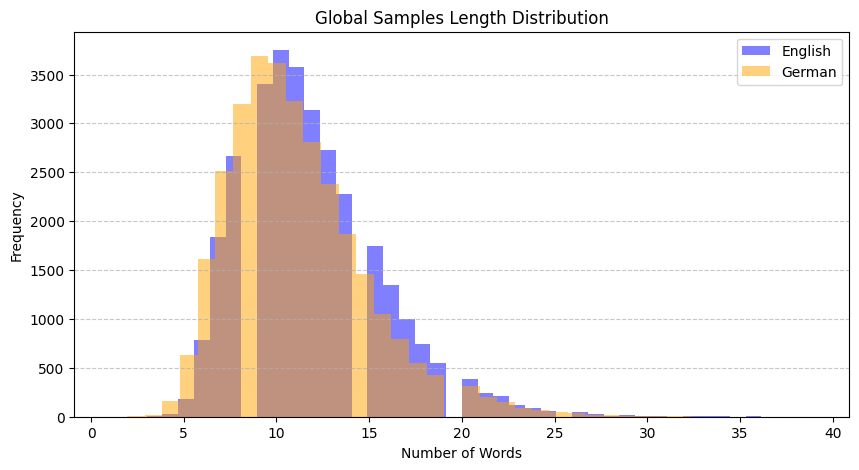

,Metric,English (en),German (de)
0,Average Word Length,4.220257,5.437838
1,Average Word Count,11.899916,11.118850
2,Max Sample Length,37.000000,39.000000


In [ ]:
quantitative_analysis(all_data)

While the maximum sentence length is sligthly higher for the German dataset, the **average word count** for sample is lower in German. This result confirms again the usage of words in the German language that symbolize complex concepts, that need to be translated with multiple words in English.

In fact, looking at the **average word length**, we notice how the average length for words in the German samples is ~30% higher compared to the English ones, which is due to the fact that compound words are more common in German.



#### Separate Splits Analysis
For completeness, the same analysis is repeated for each split separatly. It can be noticed how, in validation and test splits, the values in the histogram are more sparse and fluctuating as the number of samples is more limited.

----- train split analysis -----


,Metric,English (en),German (de)
0,Type-Token Ratio (Diversity),0.04187,0.075466
1,Rare Words % (Hapax),46.7%,60.6%


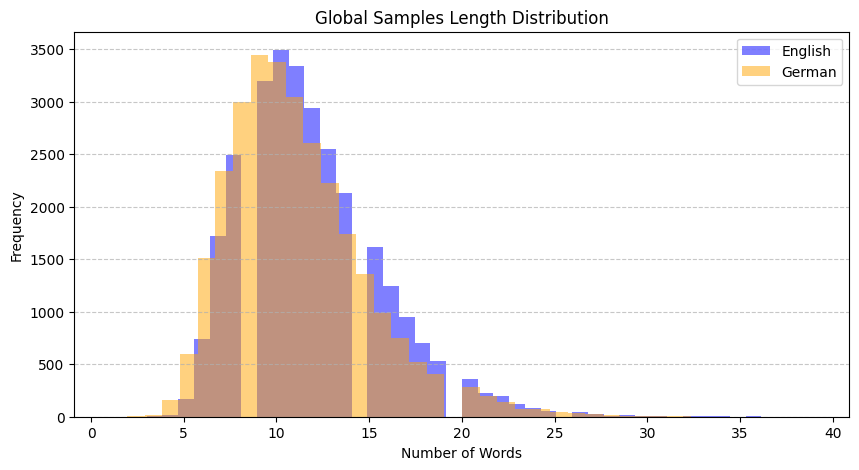

,Metric,English (en),German (de)
0,Average Word Length,4.220671,5.439145
1,Average Word Count,11.897241,11.116655
2,Max Sample Length,37.000000,39.000000


----- validation split analysis -----


,Metric,English (en),German (de)
0,Type-Token Ratio (Diversity),0.191008,0.230956
1,Rare Words % (Hapax),62.0%,68.6%


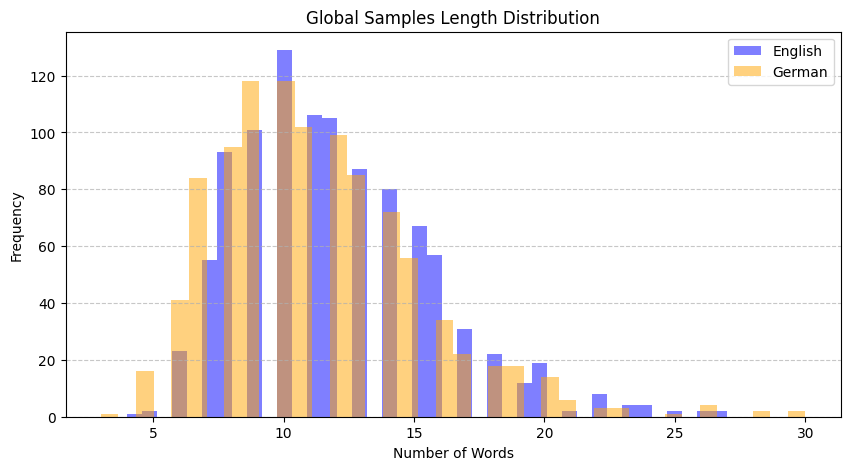

,Metric,English (en),German (de)
0,Average Word Length,4.202351,5.461565
1,Average Word Count,11.999014,11.392505
2,Max Sample Length,27.000000,30.000000


----- test split analysis -----


,Metric,English (en),German (de)
0,Type-Token Ratio (Diversity),0.191378,0.226593
1,Rare Words % (Hapax),62.3%,68.2%


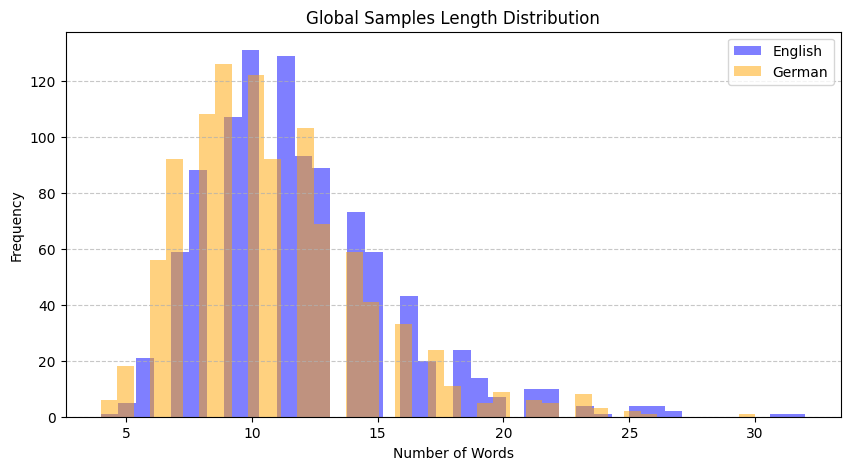

,Metric,English (en),German (de)
0,Average Word Length,4.226572,5.374049
1,Average Word Count,11.877000,10.905000
2,Max Sample Length,32.000000,30.000000


In [ ]:
for split in dataset.keys():
    print("-" * 5 + f" {split} split analysis " + "-" * 5)
    df = pd.DataFrame(dataset[split])
    display(qualitative_analysis(df))
    display(quantitative_analysis(df))

## Supervised Fine-Tuning


**Supervised Fine-Tuning (SFT)** is the traditional approach where we train the model on labeled data:

**How it works:**
- The model learns to generate summaries by minimizing the **cross-entropy loss** between predicted and target tokens
- We provide pairs of (input sentence, target translation) as training examples
- The model adjusts its weights to better predict the target translations
- This is a **direct optimization** approach - the model learns to mimic the training data

**QLoRA** provides the following additions to the finetuning process:
- Adds 4-bit quantization on top of classical SFT, to reduce memory footprint
- Makes use of **LoRA adapters**, a set of separable weights that are trained while keeping the rest of the model frozen

<img src="https://miro.medium.com/0*2meitaJ7pdUusbb5.png">

LoRA introduces a pair of rank-decomposition matrices $A$ and $B$ that are trained while keeping the model's parameter frozen. These matrices are set so that their multiplication has the same dimensions as the weights’ matrix they are intended to modify. $A$ and $B$ are then updated during the fine-tuning process while the model’s weights remain frozen, and they are utilized to compute a $\Delta W$ matrix that contains the fine-tuning adjustments. During inference, $A$ and $B$ are multiplied, and their product is summed up in the $W$ matrix, effectively updating the model’s weights.



Note that the explanation above is a simplification aimed for the theorical explanation, and that models usually have multiple sets of small matrices (the LoRA adapters), that can be trained separately.

Let's start by loading the model and its tokenizer. The model chosen for the project is the 3B version of **Llama-3.2** instruct version. The base versions of models are pre-trained on massive amount of data (the internet, books, etc.), but they are not suited for instruction following tasks. To better follow commands and answer questions, these models are then finetuned for instruction following.

In [ ]:
model, tokenizer = load_model_from_hf(model_name)
print(f"Model loaded: {model.config.model_type}")
print(f"Vocab size: {len(tokenizer)}")

==((====))==  Unsloth 2026.1.4: Fast Llama patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.35G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

Model loaded: llama
Vocab size: 128256


Let's evaluate the baseline performance of the model:

In [ ]:
original_model_translations, original_model_results = test_completions_with_sacrebleu(
    model,
    tokenizer,
    test_dataset
)
print(f"ORIGINAL MODEL STATS:")
n_gram_df, summary_df = format_sacrebleu(original_model_results)
display(n_gram_df)
display(summary_df)

100%|██████████| 125/125 [06:30<00:00,  3.12s/it]


ORIGINAL MODEL STATS:


,N-Gram,Counts,Totals,Precision (%)
0,1-gram,7646,12601,60.677724
1,2-gram,3952,11601,34.066029
2,3-gram,2235,10601,21.082917
3,4-gram,1245,9601,12.967399


,BLEU Score,Brevity Penalty (BP)
0,27.4179,1.0


As we can see, the baseline BLEU score is around 27, which marks a clear gist but often with significant errors.

Let's also show ROUGE results for completeness:

In [ ]:
format_rouge(get_rouge_scores(original_model_translations, test_dataset))

,Metric,Score
0,ROUGE1,0.6204
1,ROUGE2,0.3957
2,ROUGEL,0.5920
3,ROUGELSUM,0.5916


Let's now prepare for the finetuning and add LoRA adapters, to train just a small amount of the weights compared to the amount of trainable parameters:

In [ ]:
model = add_lora_adapters(model)
# Print trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
all_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params:,}")
print(f"All parameters: {all_params:,}")
print(f"Percentage trainable: {100 * trainable_params / all_params:.2f}%")

Unsloth 2026.1.4 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


Trainable parameters: 24,313,856
All parameters: 1,865,526,272
Percentage trainable: 1.30%


It's now time to format the data samples using the format used by Llama-3.2. When working with instruct models, that are finetuned using a specific prompt format, it's better to stick to the same format when performing additonal finetuning for specific tasks.

In [ ]:
from datasets import DatasetDict

def parse_completion_dataset(example : dict) -> str:
    """
    Combine and prompt data instances by merging the original text and the target summary using a simple prompt.
    """

    messages = [
        {
            "role" : "system",
            "content" : SYSTEM_PROMPT
        },
        {
            "role" : "user",
            "content" : example["en"]
        },
        {
            "role" : "assistant",
            "content" : example["de"]
        }
    ]

    return {"text" : tokenizer.apply_chat_template(messages, tokenize=False)}

cols = dataset.column_names

completion_ds = DatasetDict({
    split : dataset[split].map(parse_completion_dataset, remove_columns=cols[split])
    for split in dataset
})

completion_ds

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 29000
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['text'],
        num_rows: 1000
    })
})

Let's look at an example from the completion dataset:

In [ ]:
completion_ds["train"][0]

{'text': '<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 29 Jan 2026\n\nYou are a helpful assistant. Your task is to translate to German the text provided by the user.\nAnswer directly with no prehamble or comment.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nTwo young, White males are outside near many bushes.<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nZwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.<|eot_id|>'}

It's now time to begin the finetuning. As Colab offers a limited amount of time and system resources, finetuning is done with a limited amount of steps, as follows:

In [ ]:
# > Training Config
LR = 2e-4
TRAIN_BS=4
EVAL_BS=8
GRAD_ACC_STEPS=4
WARMUP_STEPS=5
WEIGHT_DECAY=0.01

MAX_STEPS=200

In [ ]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = completion_ds["train"],
    eval_dataset = completion_ds["validation"],
    args = SFTConfig(
        per_device_train_batch_size = TRAIN_BS,
        per_device_eval_batch_size = EVAL_BS,
        gradient_accumulation_steps = GRAD_ACC_STEPS,
        warmup_steps = WARMUP_STEPS,
        max_steps = MAX_STEPS,
        learning_rate = LR,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = WEIGHT_DECAY,
        lr_scheduler_type = "linear",
        seed = SEED,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=4):   0%|          | 0/29000 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=4):   0%|          | 0/1014 [00:00<?, ? examples/s]

🦥 Unsloth: Padding-free auto-enabled, enabling faster training.


As we're only interested in training on the **output** of the model (i.e. the translations), the questions are masked and only the output tokens are considered for the loss function.

In [ ]:
trainer = train_on_responses_only(
    trainer,
    **completion_kwargs,
)

Map (num_proc=6):   0%|          | 0/29000 [00:00<?, ? examples/s]

Map (num_proc=6):   0%|          | 0/1014 [00:00<?, ? examples/s]

In [ ]:
# Start training

trainer_stats = trainer.train()

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 29,000 | Num Epochs = 1 | Total steps = 200
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 24,313,856 of 3,237,063,680 (0.75% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,0.854900
2,1.085900
3,0.987800
4,1.174700
5,0.979400
6,0.958400
7,0.722300
8,1.265100
9,0.902900
10,0.810300


Let's now compare the finetuned model with the baseline one, by computing its BLEU score on the test set:

In [ ]:
finetuned_model_translations, finetuned_model_results = test_completions_with_sacrebleu(
    model,
    tokenizer,
    test_dataset
)
print(f"FINETUNED MODEL STATS:")
n_gram_df, summary_df = format_sacrebleu(finetuned_model_results)
display(n_gram_df)
display(summary_df)

100%|██████████| 125/125 [09:12<00:00,  4.42s/it]

FINETUNED MODEL STATS:


,N-Gram,Counts,Totals,Precision (%)
0,1-gram,8303,12143,68.376843
1,2-gram,4825,11143,43.300727
2,3-gram,3000,10143,29.577048
3,4-gram,1852,9143,20.255934


,BLEU Score,Brevity Penalty (BP)
0,36.4945,1.0


It can be noticed how a finetuning on a small amount of parameters performed for 200 iterations results in an increase of around 33%.

To make sense of these results, a rough guideline of  intrepretation of BLEU scores is the following one:

| BLEU Score | Interpretation |
| :--- | :--- |
| **< 10** | Almost useless |
| **10 - 19** | Hard to get the gist |
| **20 - 29** | The gist is clear, but has significant grammatical errors |
| **30 - 40** | Understandable to good translations |
| **40 - 50** | High quality translations |
| **50 - 60** | Very high quality, adequate, and fluent translations |
| **> 60** | Quality often better than human |

The improvement obtained moves the performance of the model of one band, from "The gist is clear, but has significant grammatical errors" to "Understandable to good translations". Not a bad results compared to the amount of time needed for the training!

Let's also display the ROUGE scores:

In [ ]:
format_rouge(get_rouge_scores(finetuned_model_translations, test_dataset))

,Metric,Score
0,ROUGE1,0.6849
1,ROUGE2,0.4785
2,ROUGEL,0.6557
3,ROUGELSUM,0.6556


As can be noticed, ROUGE scores improved as well: ROUGE1 improved by roughly 10%, ROUGE2 by 20%, ROUGEL by 10% and ROUGELSUM by 10%.

Let's also display the english sentences alongside the baseline translations, the one obtained after finetuning and the reference translations:

In [ ]:
display_translations(original_model_translations, finetuned_model_translations, test_dataset)

,Original Text,Baseline Translation,Finetuned Model Translation,Gold (Reference)
0,A man in an orange hat starring at something.,Ein Mann in einem Orangefarbenhut starrt auf etwas.,Ein Mann mit einem orangefarbenen Hut starrt auf etwas.,"Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt."
1,A Boston Terrier is running on lush green grass in front of a white fence.,Ein Boston Terrier läuft auf dem grünen Rasen vor einer weißen Zaun.,Ein Boston Terrier läuft auf grünem Rasen vor einem weißen Zaun.,Ein Boston Terrier läuft über saftig-grünes Gras vor einem weißen Zaun.
2,A girl in karate uniform breaking a stick with a front kick.,Eine Mädchen in einem Karateanzug bricht ein Stab mit einem Vorderkick.,Ein Mädchen in einem Karateanzug macht einen Frontkick und bricht einen Stock.,Ein Mädchen in einem Karateanzug bricht ein Brett mit einem Tritt.
3,"Five people wearing winter jackets and helmets stand in the snow, with snowmobiles in the background.","Fünf Personen, die in Wintershirts und Helme gekleidet, stehen im Schnee, mit Snowmobiles im Hintergrund.","Fünf Personen in Winterjacken und Helm stehen im Schnee, im Hintergrund sind Snowmobile zu sehen.",Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit Schneemobilen im Hintergrund.
4,People are fixing the roof of a house.,Die Menschen reparieren die Dach des Hauses.,Menschen reparieren das Dach eines Hauses.,Leute Reparieren das Dach eines Hauses.
5,A man in light colored clothing photographs a group of men wearing dark suits and hats standing around a woman dressed in a strapless gown.,"Ein Mann in leichte Kleidung fotografiert eine Gruppe von Männern in dunklen Anzügen und Hut, die sich um eine Frau in einem Strapseokostüm drängen.","Ein Mann in hellen Kleidung fotografiert eine Gruppe von Männern in dunklen Anzügen und Hüten, die sich um eine Frau in einem Kleid mit Armhöhlen herum drängen.","Ein hell gekleideter Mann fotografiert eine Gruppe von Männern in dunklen Anzügen und mit Hüten, die um eine Frau in einem trägerlosen Kleid herum stehen."
6,A group of people standing in front of an igloo.,Eine Gruppe von Menschen steht vor einem Igloo.,Eine Gruppe von Menschen steht vor einem Igloo.,Eine Gruppe von Menschen steht vor einem Iglu.
7,"A boy in a red uniform is attempting to avoid getting out at home plate, while the catcher in the blue uniform is attempting to catch him.","Ein Junge in einem roten Uniform versucht, sich an der Heimplatte zu verstecken, während der Katcher in der blauen Uniform ihn fangen versucht.","Ein Junge in einem roten Trikot versucht, sich an der Heimplatte zu verstecken, während der Catcher in einem blauen Trikot ihn fangen versucht.","Ein Junge in einem roten Trikot versucht, die Home Base zu erreichen, während der Catcher im blauen Trikot versucht, ihn zu fangen."
8,A guy works on a building.,Ein Mann arbeitet an einem Gebäude.,Ein Mann arbeitet an einem Gebäude.,Ein Typ arbeitet an einem Gebäude.
9,A man in a vest is sitting in a chair and holding magazines.,Ein Mann in einem Westen sitzt in einem Stuhl und hält Magazinen.,Ein Mann in einer Weste sitzt auf einem Stuhl und hält Magazin.,Ein Mann in einer Weste sitzt auf einem Stuhl und hält Magazine.


## GRPO Training

> Note: the following paragraph was composed starting from the explaination present in the fine-tuning laboratory seen during the course. The explanation was slightly rephrased and modified with details based on my understanding of the papers, which are focused on intuition rather than mathematical precision. Therefore, all the errors in the following text should be considered my additions.

While Supervised Fine-Tuning (SFT) directly learns from labeled examples, **Group Relative Policy Optimization (GRPO)** is a reinforcement learning-based approach that optimizes the model based on relative preferences within groups of responses.

**Key differences from SFT:**
- **SFT**: Learns to mimic exact reference translations through supervised learning
- **GRPO**: Learns to generate better translations by comparing multiple candidates and optimizing for quality metrics through reinforcement learning

---

#### What is GRPO?

**Group Relative Policy Optimization** is a reinforcement learning algorithm designed for training large language models, introduced in the paper [*DeepSeekMath: Pushing the Limits of Mathematical Reasoning in Open Language Models*](https://huggingface.co/papers/2402.03300) (2024).

GRPO is a variant of Proximal Policy Optimization (PPO) that enhances mathematical reasoning capabilities while optimizing memory usage. The key innovation is its **group-relative advantage calculation**, which normalizes rewards across multiple completions generated for the same prompt, aligning with the comparative nature of reward models.

**Why GRPO over PPO?** GRPO removes the dependency on the value model, a neural network that evaluates the goodness of being in a specific state, which becomes inaccurate for long text outputs and complex tasks. This makes GRPO more scalable and efficient. As the value model is used to compute the advantage over a baseline, the concept of baseline is effectively replaced by the comparison with other completions.

---

#### How GRPO Works

GRPO is an **online learning algorithm** that improves iteratively through four main steps:

##### 1. **Generating Completions**
For each prompt $x$, the model generates $K$ different completions: $\{y_1, y_2, \ldots, y_K\}$

##### 2. **Computing the Advantage**
The advantage for each completion is calculated using group normalization:

$$\hat{A_i} = \frac{r_i - \text{mean}(r)}{\text{std}(r)}$$

where $r_i$ is the reward for completion $i$, and the mean and standard deviation are computed across all $K$ completions for the same prompt.

> **Note:** The original formulation includes division by $\text{std}(r)$, but recent research suggests that disabling this scaling (by setting `scale_rewards=False`) can reduce question-level difficulty bias.

##### 3. **Estimating KL Divergence**
KL divergence between the current policy $\pi_\theta$ and reference policy $\pi_{\text{ref}}$ is estimated to prevent the model from deviating too far from the reference.

##### 4. **Computing the Loss**
The GRPO objective maximizes the advantage while constraining the policy update using a clipped surrogate objective:

$$
ℒ_{\text{GRPO}}(\theta) = -\mathbb{E} \left[ \min \left( r_t(\theta)\hat{A_~}, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) \hat{A_~} \right) \right] + \beta \cdot D_{\text{KL}}(\pi_\theta || \pi_{\text{ref}})
$$

where:
- $r_t(\theta) = \frac{\pi_\theta(y_t|x, y_{<t})}{\pi_{\text{ref}}(y_t|x, y_{<t})}$ is the **importance sampling ratio** (token-level)
- $\epsilon$ is the clipping parameter (typically 0.2)
- $\beta$ is the KL coefficient (often set to 0 in practice)

The ratio $r_t(\theta)$ allows us to evaluate the new policy using data from the old policy, avoiding expensive resampling. However, if the gap between policies is too large, this ratio can have high variance, leading to instability.

This ratio is clipped to ensure the proximity policy, as a very high reward would encourage the model to explore more "extreme" paths, leading to instable behaviors.

![GRPO Visual](https://huggingface.co/datasets/trl-lib/documentation-images/resolve/main/grpo_visual.png)

---

#### GRPO's Limitations

While GRPO improves upon PPO, it has several key limitations that motivated further research. The following limitations are addressed by DAPO, a more stable version of GRPO that was therefore chosen for the experiments:

1. **Response-Level Length Bias**: Longer responses are under-penalized in the original formulation
2. **Inefficient Sampling**: When all samples have similar rewards (all good or all bad), gradient contributions become zero
3. **Token Gradient Dilution**: In long sequences, individual token gradients get diluted

---
The [**DAPO paper**](https://huggingface.co/papers/2503.14476) (*DAPO: An Open-Source LLM Reinforcement Learning System at Scale*) introduced four key improvements to address GRPO's efficiency and stability issues.

#### **DAPO Improvement #1: Clip-Higher**

**The Problem:** GRPO's symmetric clipping range $[1-\epsilon, 1+\epsilon]$ causes "good tokens being capped too early." When the old policy assigns very low probability to a good token (positive advantage), the current policy has little room to increase its probability before being clipped.

**Example:** If the old policy probability is 0.2 and $\epsilon=0.2$, the upper bound is $0.2 \times 1.2 = 0.24$. Even if the current policy increases it to 0.4 (a good improvement!), it gets clipped.

**The Solution:** DAPO raises the upper clipping bound while keeping the lower bound fixed, giving the model more room to reinforce good tokens that were previously unlikely.

---

#### **DAPO Improvement #2: Dynamic Sampling**

**The Problem:** When all sampled responses have the same reward (all 0 or all 1), they all receive zero advantage after normalization, contributing zero gradient. This wastes computation and increases variance.

**The Solution:** Enforce that for each query, the sampled responses must contain both correct and incorrect answers:

$$\exists i, j: r_i \neq r_j$$

If all samples have identical rewards, continue sampling until diversity is achieved.

---

#### **DAPO Improvement #3: Token-Level Gradient Loss**

**The Problem:** The original GRPO normalizes loss by individual sequence length:

$$ℒ_{\text{GRPO-original}}(\theta) = -\frac{1}{|y|}\sum_{t=1}^{|y|}\min(r_t(\theta) \hat{A_~} , \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat{A_~})$$

This causes longer responses to be under-penalized. A 200-token response gives each token weight $\frac{1}{200}$, while a 10-token response gives each token weight $\frac{1}{10}$, making shorter responses dominate the gradient.

As the DAPO paper states, the original GRPO algorithm employs a sample-level loss calculation, which involves first averaging the losses by token within each sample and then aggregating the losses across samples. In this approach, each sample is assigned an equal weight in the final loss computation.

Since all samples are assigned the same weight in the loss calculation, tokens within longer responses (which contain more tokens) may have a disproportionately lower contribution to the overall loss, which can lead to two adverse effects. First, for high-quality long samples, this effect can impede the model’s ability to learn
reasoning-relevant patterns within them. Second, excessively long samples often exhibit low-quality patterns such as gibberish and repetitive words.

**The Solution:** DAPO proposes **token-level normalization** across the entire batch:

$$ℒ_{\text{DAPO}}(\theta) = -\frac{1}{\sum_i |y_i|}\sum_{i}\sum_{t=1}^{|y_i|}\min(r_t^{(i)}(\theta)\hat{A_~}_i, \text{clip}(r_t^{(i)}(\theta), 1-\epsilon, 1+\epsilon)\hat{A_~}_i)$$

This treats all tokens equally regardless of response length, preventing gradient signals from being diluted in long, high-quality responses.

---

#### **DAPO Improvement #4: Overlong Reward Shaping**

**The Problem:** Overly long responses can receive high rewards even when they contain unnecessary verbosity or repetition.

**The Solution:** Apply a soft penalty to tokens once the sequence exceeds a predefined length threshold. The penalty increases linearly, and if a second threshold is exceeded, the penalty can cancel out the original reward entirely.

**Usage in TRL:** Set `loss_type="bnpo"` (default in the current implementation)

---


Let's perform another training process with GRPO. Firstly, load again the model:

In [ ]:
grpo_model, grpo_tokenizer = load_model_from_hf(model_name)
grpo_model = add_lora_adapters(grpo_model)

==((====))==  Unsloth 2026.1.4: Fast Llama patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Next, prepare the data for the GRPO training. As can be seen by the training sample printed below, the format is slightly different compared to the one used in Supervised Fine-Tuning, as GRPO needs the gold answer separately from the prompt passed to the model, in order to compute the rewards.

In [ ]:
def prepare_grpo_dataset(example):
    """
    Prepare dataset for GRPO training.
    GRPO needs prompts (queries) and reference completions for reward calculation.
    """
    msg = [
        {
            "role": "system",
            "content": SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": example["en"]
        }
    ]

    return {
        "prompt": msg,
        "reference": example["de"]  # Gold standard for reward calculation
    }

# Prepare GRPO dataset
grpo_dataset = dataset["train"].map(prepare_grpo_dataset, remove_columns=dataset["train"].column_names)
grpo_eval_dataset = dataset["validation"].map(prepare_grpo_dataset, remove_columns=dataset["validation"].column_names)

print(f"GRPO Training samples: {len(grpo_dataset)}")
print(f"GRPO Validation samples: {len(grpo_eval_dataset)}")
print("\nExample query:")
print(json.dumps(grpo_dataset[0], indent=2))

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

GRPO Training samples: 29000
GRPO Validation samples: 1014

Example query:
{
  "prompt": [
    {
      "content": "\nYou are a helpful assistant. Your task is to translate to German the text provided by the user.\nAnswer directly with no prehamble or comment.\n",
      "role": "system"
    },
    {
      "content": "Two young, White males are outside near many bushes.",
      "role": "user"
    }
  ],
  "reference": "Zwei junge wei\u00dfe M\u00e4nner sind im Freien in der N\u00e4he vieler B\u00fcsche."
}


Let's now define the reward functions. The first one simply computes the BLEU score on the model's completions:

In [ ]:
def sacrebleu_reward_function(completions,
                          reference,**kwargs):
    res = []
    for i in range(len(completions)):
        res.append(sacrebleu.compute(
            predictions=[completions[i][0]["content"]],
            references=[reference[i]],
        )["score"] / 100)
    return res

GRPO can be used to enforce specific high-level properties of the output, such as the output length. To make use of this feature, let's also define a reward function that penalizes the model based on the difference of its output compared to the gold reference.

As the BLEU metric penalizes too short translations itself, let's only penalize too long ones.

In [ ]:
print("\n--- Length Statistics ---")
english_token_counts = [len(grpo_tokenizer.tokenize(example["en"])) for example in tqdm(dataset["train"])]
german_token_counts = [len(grpo_tokenizer.tokenize(example["de"])) for example in tqdm(dataset["train"])]

print(f"English - Average tokens: {np.mean(english_token_counts):.2f}")
print(f"English - Minimum tokens: {np.min(english_token_counts)}")
print(f"English - Maximum tokens: {np.max(english_token_counts)}")

print(f"\nGerman - Average tokens: {np.mean(german_token_counts):.2f}")
print(f"German - Minimum tokens: {np.min(german_token_counts)}")
print(f"German - Maximum tokens: {np.max(german_token_counts)}")


--- Length Statistics ---


100%|██████████| 29000/29000 [00:04<00:00, 7101.74it/s]

English - Average tokens: 13.54
English - Minimum tokens: 4
English - Maximum tokens: 43

German - Average tokens: 19.65
German - Minimum tokens: 1
German - Maximum tokens: 76


In [ ]:
def length_reward_function(completions, reference, **kwargs):
    """
    Compute length-based reward with bounded exponential decay.
    """
    penalized_rewards = []

    for i, completion in enumerate(completions):
        ref = reference[i]
        reference_length = len(grpo_tokenizer.tokenize(ref, return_tensors="np"))

        completion_length = len(grpo_tokenizer.tokenize(completion[0]["content"], return_tensors="np"))
        length_diff = max(0, completion_length - reference_length)

        decay_rate = 0.5
        normalized_diff = length_diff / reference_length

        reward = math.exp(-decay_rate * normalized_diff)
        penalized_rewards.append(reward)

    return penalized_rewards

Let's now load the GRPO Trainer from Unsloth and proceed with the training. As for SFT, training is done with a limited amount of steps.

In [ ]:
# GRPO Training Configuration
grpo_config = GRPOConfig(
    output_dir="./grpo_outputs",
    num_train_epochs=1,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=2,
    learning_rate=5e-6,             # Lower LR for RL fine-tuning
    max_steps=500,                   # Limited for demonstration
    logging_steps=1,

    # GRPO-specific parameters
    num_generations=4,  # Generate 4 candidates per prompt for comparison (the higher the better - more exploration)
    max_completion_length=76,  # Maximum translation length
    temperature=0.9,    # Sampling temperature for generation
    top_k=50,
    top_p=0.95,
    repetition_penalty=1.2,
    generation_kwargs={
      "min_new_tokens" : 1,
      "use_cache" : True, # use KV Cache
    },

    # GRPO config (DAPO)
    loss_type="bnpo",
    beta=0.0,
    epsilon_high=0.28, # recommended by the DAPO paper

    # Optimization
    fp16=not is_bfloat16_supported(),
    bf16=is_bfloat16_supported(),
    optim="adamw_8bit",

    seed=SEED,
    report_to="none"
)

print("GRPO Configuration:")
print(f"  Batch size: {grpo_config.per_device_train_batch_size}")
print(f"  Learning rate: {grpo_config.learning_rate}")
print(f"  Generations per prompt: {grpo_config.num_generations}")
print(f"  Max steps: {grpo_config.max_steps}")

GRPO Configuration:
  Batch size: 2
  Learning rate: 5e-06
  Generations per prompt: 4
  Max steps: 500


In [ ]:
# Initialize GRPO Trainer
grpo_trainer = GRPOTrainer(
    model=grpo_model,
    args=grpo_config,
    train_dataset=grpo_dataset,
    tokenizer=grpo_tokenizer,
    reward_funcs=[
        sacrebleu_reward_function,
        length_reward_function
    ]
)

print("GRPO Trainer initialized successfully!")

GRPO Trainer initialized successfully!


In [ ]:
# Train with GRPO
grpo_trainer_stats = grpo_trainer.train()

print("GRPO Training completed!")
print(grpo_trainer_stats)

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 29,000 | Num Epochs = 1 | Total steps = 500
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 2 x 1) = 4
 "-____-"     Trainable parameters = 24,313,856 of 3,237,063,680 (0.75% trained)
`generation_config` default values have been modified to match model-specific defaults: {'max_length': 131072}. If this is not desired, please set these values explicitly.


Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,sampling / sampling_logp_difference / mean,sampling / sampling_logp_difference / max,sampling / importance_sampling_ratio / min,sampling / importance_sampling_ratio / mean,sampling / importance_sampling_ratio / max,kl,rewards / sacrebleu_reward_function / mean,rewards / sacrebleu_reward_function / std,rewards / length_reward_function / mean,rewards / length_reward_function / std
1,0.000000,1.355734,0.174100,15.250000,13.000000,18.000000,0.000000,15.250000,13.000000,18.000000,0,0,0,0,0,0.000000,0.419326,0.168354,0.936408,0.060728
2,0.000000,0.871790,0.114899,29.000000,23.000000,36.000000,0.000000,29.000000,23.000000,36.000000,No Log,No Log,No Log,No Log,No Log,0.000000,0.047614,0.016149,0.824177,0.108234
3,0.000000,1.240644,0.096760,15.750000,15.000000,17.000000,0.000000,15.750000,15.000000,17.000000,No Log,No Log,No Log,No Log,No Log,0.000000,0.240644,0.096760,1.000000,0.000000
4,0.000000,1.215502,0.046500,11.250000,11.000000,12.000000,0.000000,11.250000,11.000000,12.000000,No Log,No Log,No Log,No Log,No Log,0.000000,0.215502,0.046500,1.000000,0.000000
5,0.000000,0.970405,0.114458,20.250000,18.000000,23.000000,0.000000,20.250000,18.000000,23.000000,No Log,No Log,No Log,No Log,No Log,0.000000,0.099996,0.055459,0.870409,0.075964
6,0.000000,1.046662,0.076590,24.250000,22.000000,28.000000,0.000000,24.250000,22.000000,28.000000,No Log,No Log,No Log,No Log,No Log,0.000000,0.129247,0.036339,0.917415,0.053138
7,-0.000000,1.032706,0.075456,18.000000,16.000000,21.000000,0.000000,18.000000,16.000000,21.000000,No Log,No Log,No Log,No Log,No Log,0.000000,0.095404,0.009938,0.937301,0.066024
8,0.000000,1.163440,0.046518,14.500000,14.000000,16.000000,0.000000,14.500000,14.000000,16.000000,No Log,No Log,No Log,No Log,No Log,0.000000,0.163440,0.046518,1.000000,0.000000
9,0.000000,1.173154,0.152535,17.500000,17.000000,18.000000,0.000000,17.500000,17.000000,18.000000,No Log,No Log,No Log,No Log,No Log,0.000000,0.173154,0.152535,1.000000,0.000000
10,-0.000000,1.300851,0.039616,7.500000,7.000000,8.000000,0.000000,7.500000,7.000000,8.000000,No Log,No Log,No Log,No Log,No Log,0.000000,0.300851,0.039616,1.000000,0.000000


Unsloth: Will smartly offload gradients to save VRAM!
GRPO Training completed!
TrainOutput(global_step=500, training_loss=-2.9727816581726076e-08, metrics={'train_runtime': 1990.0439, 'train_samples_per_second': 1.005, 'train_steps_per_second': 0.251, 'total_flos': 0.0, 'train_loss': -2.9727816581726076e-08})


Let's now evaluate the model finetuned with GRPO, using the same test split that we've used in SFT:

In [ ]:
grpo_model_translations, grpo_model_results = test_completions_with_sacrebleu(
    model,
    tokenizer,
    test_dataset
)
print(f"GRPO MODEL STATS:")
n_gram_df, summary_df = format_sacrebleu(grpo_model_results)
display(n_gram_df)
display(summary_df)

100%|██████████| 125/125 [09:09<00:00,  4.40s/it]

GRPO MODEL STATS:


,N-Gram,Counts,Totals,Precision (%)
0,1-gram,8333,12176,68.437911
1,2-gram,4846,11176,43.360773
2,3-gram,3024,10176,29.716981
3,4-gram,1880,9176,20.488230


,BLEU Score,Brevity Penalty (BP)
0,36.6628,1.0


We can see how the results is comparable to the one obtained with Supervised Fine-Tuning. Once again, a small training resulted in an increase, of around 33% on the BLEU score in this case.

Although not trained directly on them, let's also take a look at the ROUGE scores:

In [ ]:
format_rouge(get_rouge_scores(grpo_model_translations, test_dataset))

,Metric,Score
0,ROUGE1,0.6848
1,ROUGE2,0.4775
2,ROUGEL,0.6542
3,ROUGELSUM,0.6541


As can be noticed, although GRPO didn't train specifically on ROUGE, it still shows an increase compared to the base model. Specifically, ROUGE1 increased by 10%, ROUGE2 by 20%, ROUGEL by 10% and ROUGELSUM by 10%, similarly to the previous SFT finetuning.

Let's also display for the GPRO model the english sentences alongside the baseline translations, the translations obtained from inference after finetuning and the reference translations:

In [ ]:
display_translations(original_model_translations, grpo_model_translations, test_dataset)

,Original Text,Baseline Translation,Finetuned Model Translation,Gold (Reference)
0,A man in an orange hat starring at something.,Ein Mann in einem Orangefarbenhut starrt auf etwas.,Ein Mann mit orangefarbenem Hut starrt auf etwas.,"Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt."
1,A Boston Terrier is running on lush green grass in front of a white fence.,Ein Boston Terrier läuft auf dem grünen Rasen vor einer weißen Zaun.,Ein Boston Terrier läuft auf grünem Rasen vor einem weißen Zaun.,Ein Boston Terrier läuft über saftig-grünes Gras vor einem weißen Zaun.
2,A girl in karate uniform breaking a stick with a front kick.,Eine Mädchen in einem Karateanzug bricht ein Stab mit einem Vorderkick.,Ein Mädchen in einem Karateanzug schlägt mit einem Frontkick einen Stock.,Ein Mädchen in einem Karateanzug bricht ein Brett mit einem Tritt.
3,"Five people wearing winter jackets and helmets stand in the snow, with snowmobiles in the background.","Fünf Personen, die in Wintershirts und Helme gekleidet, stehen im Schnee, mit Snowmobiles im Hintergrund.",Fünf Personen in Winterjacken und Helm stehen im Schnee und im Hintergrund sind Snowmobile zu sehen.,Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit Schneemobilen im Hintergrund.
4,People are fixing the roof of a house.,Die Menschen reparieren die Dach des Hauses.,Menschen reparieren das Dach eines Hauses.,Leute Reparieren das Dach eines Hauses.
5,A man in light colored clothing photographs a group of men wearing dark suits and hats standing around a woman dressed in a strapless gown.,"Ein Mann in leichte Kleidung fotografiert eine Gruppe von Männern in dunklen Anzügen und Hut, die sich um eine Frau in einem Strapseokostüm drängen.","Ein Mann in hellen Kleidung fotografiert eine Gruppe von Männern in dunklen Anzügen und Hüten, die sich um eine Frau in einem Kleid mit Armhöhlen herum drängen.","Ein hell gekleideter Mann fotografiert eine Gruppe von Männern in dunklen Anzügen und mit Hüten, die um eine Frau in einem trägerlosen Kleid herum stehen."
6,A group of people standing in front of an igloo.,Eine Gruppe von Menschen steht vor einem Igloo.,Eine Gruppe von Leuten steht vor einem Igloo.,Eine Gruppe von Menschen steht vor einem Iglu.
7,"A boy in a red uniform is attempting to avoid getting out at home plate, while the catcher in the blue uniform is attempting to catch him.","Ein Junge in einem roten Uniform versucht, sich an der Heimplatte zu verstecken, während der Katcher in der blauen Uniform ihn fangen versucht.","Ein Junge in einem roten Trikot versucht, sich an der Heimplatte zu verstecken, während der Catcher in einem blauen Trikot versucht, ihn zu fangen.","Ein Junge in einem roten Trikot versucht, die Home Base zu erreichen, während der Catcher im blauen Trikot versucht, ihn zu fangen."
8,A guy works on a building.,Ein Mann arbeitet an einem Gebäude.,Ein Mann arbeitet an einem Gebäude.,Ein Typ arbeitet an einem Gebäude.
9,A man in a vest is sitting in a chair and holding magazines.,Ein Mann in einem Westen sitzt in einem Stuhl und hält Magazinen.,Ein Mann in einer Weste sitzt auf einem Stuhl und hält Magazin.,Ein Mann in einer Weste sitzt auf einem Stuhl und hält Magazine.
